In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
import cv2
from torch.utils.data import Dataset, DataLoader

PATH = "kaggle_3m"
IMAGE_SIZE = (256, 256)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

paths = []

for dirname in os.listdir(PATH):
    if os.path.isdir(os.path.join(PATH, dirname)):
        
        for filename in os.listdir(os.path.join(PATH, dirname)):
            if filename.endswith('.tif'):
                paths.append(PATH+'/'+dirname+'/'+filename)


def data_frame(data):
    images = list(filter(lambda x: not x.endswith('mask.tif'), data))
    images.sort(key=lambda x: int(x.rsplit('_', 3)[-1][:-4]))
    images.sort(key=lambda x: int(x.rsplit('_', 3)[-2]))
    
    IDs = list(map(lambda x: x.rsplit('/', 3)[-1][:-4], images))

    masks = list(filter(lambda x: x.endswith('mask.tif'), data))
    masks.sort(key=lambda x: int(x.rsplit('_', 3)[-2]))
    masks.sort(key=lambda x: int(x.rsplit('_', 3)[-3]))

    pixels = lambda x: Image.open(x)
    largest_pixel = lambda y: np.max(pixels(y))
    diagnotic_function = lambda z: 1 if largest_pixel(z) > 0 else 0
    diagnoses = list(map(lambda x: diagnotic_function(x), masks))

    data_df = pd.DataFrame({'ID': IDs, 'Image': images, 'Mask': masks, 'Diagnosis': diagnoses})
    
    train_index, val_index = train_test_split(data_df.index.values.tolist(), test_size=0.19, random_state=42)
    val_index, test_index = train_test_split(val_index, test_size=0.12, random_state=42)
    
    # Making train, test, and validation dataframes
    train_df, val_df, test_df = data_df.iloc[train_index], data_df.iloc[val_index], data_df.iloc[test_index]
    
    return train_df, val_df, test_df
    
# Making the dataframes
train_df, val_df, test_df = data_frame(paths)

print(len(train_df), len(val_df), len(test_df))

print(train_df.head())

def tensor_from_path(path):
    arr = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    arr = cv2.resize(arr, IMAGE_SIZE)
    arr = arr / 255
    if len(arr.shape) == 3:
        tensor = torch.tensor(arr).permute(2,0,1)
    elif len(arr.shape) == 2:
        tensor = torch.tensor(arr).unsqueeze(0)
    else:
        raise ValueError(f"Expected data shape to be (..., ..., 3) or (..., ...) , but got {arr.shape}")
    return tensor

class data(Dataset):
    def __init__(self, df):
        super().__init__()
        self.df = df        
        self.images = self.df.loc[:,'Image'].values
        self.masks = self.df.loc[:,'Mask'].values
        self.diagnosis = self.df.loc[:,'Diagnosis'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        im_path = self.images[idx]
        msk_path= self.masks[idx]
        diagnosis = self.diagnosis[idx]
        self.im_tensor = tensor_from_path(im_path)
        self.msk_tensor= tensor_from_path(msk_path)
        return self.im_tensor.to(device), self.msk_tensor.to(device),diagnosis

train_ds = data(train_df)
test_ds = data(test_df)

train_dl = DataLoader(train_ds, batch_size=32)
test_dl = DataLoader(test_ds, batch_size=32)

cpu
3182 657 90
                            ID  \
812   TCGA_DU_7302_19911203_33   
1550  TCGA_HT_7602_19951103_17   
2228  TCGA_DU_A5TR_19970726_31   
1108  TCGA_DU_5872_19950223_26   
3728  TCGA_FG_7643_20021104_17   

                                                  Image  \
812   kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_1...   
1550  kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_1...   
2228  kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_1...   
1108  kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_1...   
3728  kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_2...   

                                                   Mask  Diagnosis  
812   kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_1...          0  
1550  kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_1...          0  
2228  kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_1...          0  
1108  kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_1...          0  
3728  kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_2...          0  


Number of training images: 3182
Number of validation images: 657
Number of test images: 90
Diagnosis distribution in training set:
Diagnosis
0    2075
1    1107
Name: count, dtype: int64


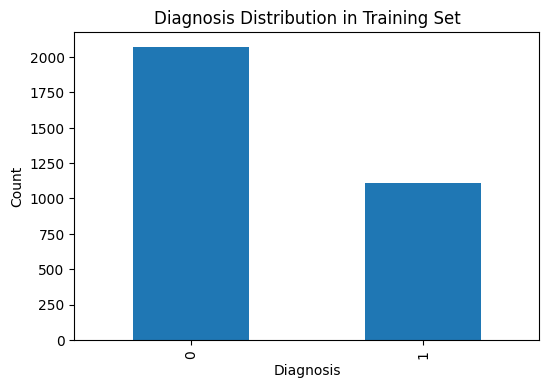

In [2]:
import matplotlib.pyplot as plt

# Number of images in each dataset
num_train_images = len(train_df)
num_val_images = len(val_df)
num_test_images = len(test_df)

print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_val_images}")
print(f"Number of test images: {num_test_images}")

# Distribution of diagnoses in training set
diagnosis_counts = train_df['Diagnosis'].value_counts()
print("Diagnosis distribution in training set:")
print(diagnosis_counts)

# Plotting the distribution
plt.figure(figsize=(6, 4))
diagnosis_counts.plot(kind='bar')
plt.title('Diagnosis Distribution in Training Set')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()


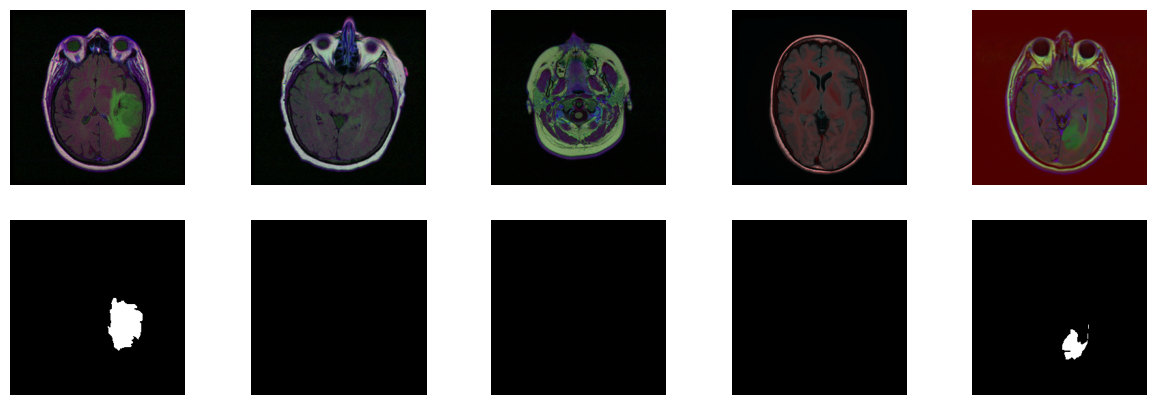

In [3]:
# Visualizing random samples from the training set
import random

def show_random_images(df, num_images=5):
    plt.figure(figsize=(15, 5))
    random_images = df.sample(num_images)
    for i, row in enumerate(random_images.itertuples()):
        image = Image.open(row.Image)
        mask = Image.open(row.Mask)
        plt.subplot(2, num_images, i + 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(mask, cmap='gray')
        plt.axis('off')
    plt.show()

show_random_images(train_df)


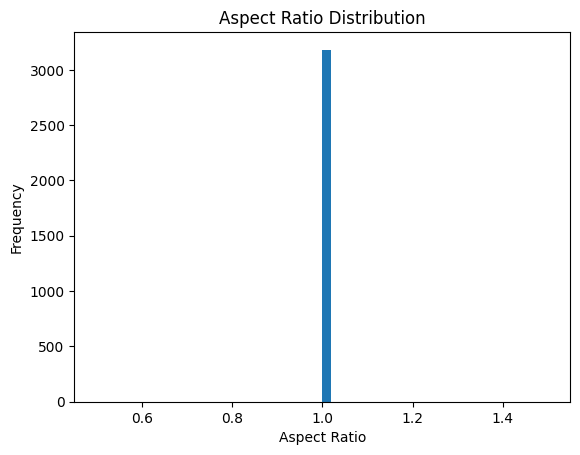

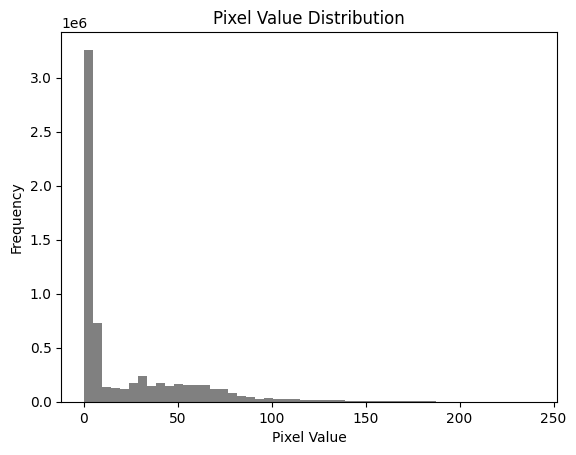

In [4]:
# Aspect Ratios
aspect_ratios = []

for row in train_df.itertuples():
    image = Image.open(row.Image)
    width, height = image.size
    aspect_ratios.append(width / height)

plt.hist(aspect_ratios, bins=50)
plt.title('Aspect Ratio Distribution')
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')
plt.show()

# Pixel Value Distribution
all_pixels = []

for row in train_df.sample(100).itertuples():  # sampling 100 images for pixel distribution
    image = Image.open(row.Image).convert('L')  # converting to grayscale
    pixels = np.array(image).flatten()
    all_pixels.extend(pixels)

plt.hist(all_pixels, bins=50, color='gray')
plt.title('Pixel Value Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()


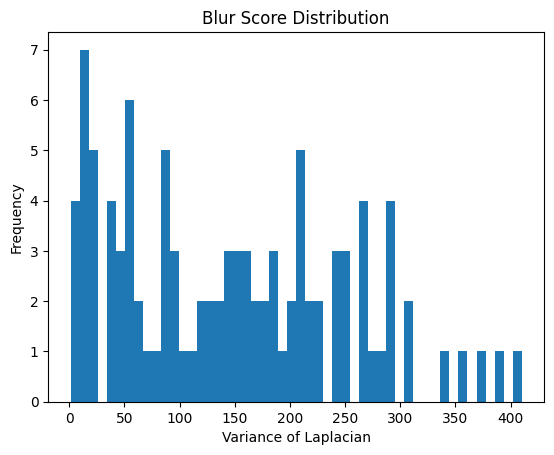

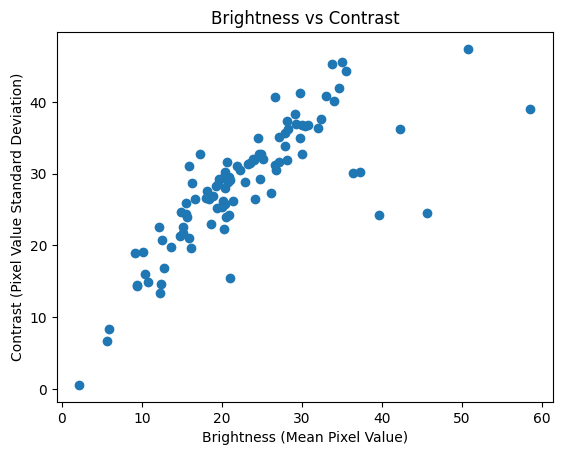

In [5]:
# Blur Detection
def variance_of_laplacian(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()

blur_scores = []

for row in train_df.sample(100).itertuples():  # sampling 100 images for blur detection
    image = cv2.imread(row.Image, cv2.IMREAD_GRAYSCALE)
    blur_scores.append(variance_of_laplacian(image))

plt.hist(blur_scores, bins=50)
plt.title('Blur Score Distribution')
plt.xlabel('Variance of Laplacian')
plt.ylabel('Frequency')
plt.show()

# Brightness and Contrast
brightness = []
contrast = []

for row in train_df.sample(100).itertuples():  # brightness, contrast
    image = cv2.imread(row.Image, cv2.IMREAD_GRAYSCALE)
    brightness.append(np.mean(image))
    contrast.append(np.std(image))

plt.scatter(brightness, contrast)
plt.title('Brightness vs Contrast')
plt.xlabel('Brightness (Mean Pixel Value)')
plt.ylabel('Contrast (Pixel Value Standard Deviation)')
plt.show()


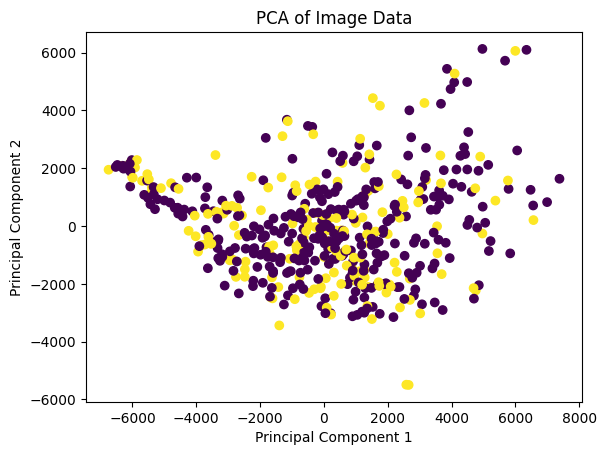

In [9]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Extract features using a simple flattened image representation for PCA and t-SNE
flattened_images = []

for row in train_df.sample(500).itertuples():  # sampling 500 images for PCA and t-SNE
    image = cv2.imread(row.Image, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, IMAGE_SIZE).flatten()
    flattened_images.append(image)



# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(flattened_images)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=train_df.sample(500)['Diagnosis'])
plt.title('PCA of Image Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


